In [6]:
from cache_em_all import Cachable
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
import pandas as pd
import os
import numpy as np

# Load data 

In [7]:
DATA_DIR = "../data/raw/training" # Path to the data

def load_single_file(file_path):
    df = pd.read_csv(file_path, sep='|')
    df['hours'] = df.index
    df['patient'] = file_path[22:-4]
    return df
    
def get_data_files():
    return [os.path.join(DATA_DIR, x) for x in sorted(os.listdir(DATA_DIR)) if int(x[1:-4]) % 5 > 0]

@Cachable('data_unclean.csv')
def load_data():
    data = get_data_files()
    data_frames = [load_single_file(d) for d in data]
    merged = pd.concat(data_frames)
    return merged

In [8]:
df = load_data()
df.columns

Index(['HR', 'O2Sat', 'Temp', 'SBP', 'MAP', 'DBP', 'Resp', 'EtCO2',
       'BaseExcess', 'HCO3', 'FiO2', 'pH', 'PaCO2', 'SaO2', 'AST', 'BUN',
       'Alkalinephos', 'Calcium', 'Chloride', 'Creatinine', 'Bilirubin_direct',
       'Glucose', 'Lactate', 'Magnesium', 'Phosphate', 'Potassium',
       'Bilirubin_total', 'TroponinI', 'Hct', 'Hgb', 'PTT', 'WBC',
       'Fibrinogen', 'Platelets', 'Age', 'Gender', 'Unit1', 'Unit2',
       'HospAdmTime', 'ICULOS', 'SepsisLabel', 'hours', 'patient'],
      dtype='object')

EtCO2 column is null for every patient, so we drop it

In [9]:
df.pop('EtCO2')

0    NaN
1    NaN
2    NaN
3    NaN
4    NaN
      ..
28   NaN
29   NaN
30   NaN
31   NaN
32   NaN
Name: EtCO2, Length: 631260, dtype: float64

In [10]:
mean_dict = df.mean().to_dict()

In [11]:
one = df.loc[df['patient'] == 1]

Let's examine patient one's heartrate, with the gaps being the missing values:

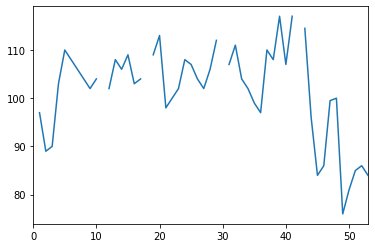

In [12]:
one["HR"].plot()

## note: imputing with mean first then splitting into train/test sets is bad practice

Iteratively imputes series for each patient with Bayesian Ridge Regression

In [13]:
@Cachable('data_clean.csv')
def fill_missing(data_frame):
    result = pd.DataFrame()
    for patient, df in data_frame.groupby('patient'):
        empty = df.columns[df.isnull().all()].to_list()
        means = dict([(key, d[key]) for key in empty])
        df = df.fillna(means)
        imp = IterativeImputer()
        df[:] = imp.fit_transform(df)
        result = pd.concat([result, df])
    return result

In [133]:
filled = fill_missing(df)

Our imputation is filling in values:

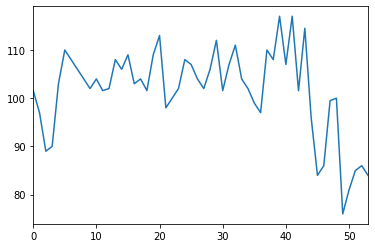

In [15]:
filled.loc[filled['patient'] ==1]['HR'].plot()

In [16]:
filled.isnull().any()

HR                  False
O2Sat               False
Temp                False
SBP                 False
MAP                 False
DBP                 False
Resp                False
BaseExcess          False
HCO3                False
FiO2                False
pH                  False
PaCO2               False
SaO2                False
AST                 False
BUN                 False
Alkalinephos        False
Calcium             False
Chloride            False
Creatinine          False
Bilirubin_direct    False
Glucose             False
Lactate             False
Magnesium           False
Phosphate           False
Potassium           False
Bilirubin_total     False
TroponinI           False
Hct                 False
Hgb                 False
PTT                 False
WBC                 False
Fibrinogen          False
Platelets           False
Age                 False
Gender              False
Unit1               False
Unit2               False
HospAdmTime         False
ICULOS      

# Train preliminary models

In [19]:
from sklearn.metrics import precision_score, recall_score, accuracy_score, roc_auc_score, f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from rfpimp import *

In [20]:
X = filled.loc[:,filled.columns != 'SepsisLabel']
y = filled['SepsisLabel']

In [21]:
def train_stratified(data, feature_cols, label_col, stratify_col, model, return_model=False):
    test_size=0.1
    rs = np.random.RandomState(3)
    all_ids = data['patient'].unique()
    
    case_ids = data[data['SepsisLabel'] == 1]['patient'].unique()
    tvt_perm = rs.permutation(len(all_ids)) #train/val/test permutation of indices
    split_size = int(test_size*len(all_ids))
    test_ind = tvt_perm[:split_size]
    test_ids = all_ids[test_ind]
    train_ind = tvt_perm[split_size:]
    train_ids = all_ids[train_ind]
    test_prev = len(set(test_ids).intersection(case_ids))/len(test_ids)
    
    print('Proportion of positive patients in test set:',test_prev)
    print('train',len(train_ids))
    print('test', len(test_ids))
    print('Sum', len(train_ids) + len(test_ids))
    print('Total', len(all_ids))
    
    train = data[data['patient'].isin(train_ids)]
    test = data[data['patient'].isin(test_ids)]

    
    clf = model
    X_train = train[feature_cols]
    y_train = train[label_col]
    clf.fit(X_train, y_train)
    y_pred_train = clf.predict(X_train)
    print('F1 for train',f1_score(y_train, y_pred_train))
    
    X_test = test[feature_cols]
    y_test = test[label_col]
    y_pred_test = clf.predict(X_test)
    probs = clf.predict_proba(X_test)
    y_pred_proba = np.array([i[1] for i in probs])

    print('F1 for test', f1_score(y_test, y_pred_test))
    
    # Come back to this, install sklearn 0.22
#     print('AUCPUR', precision_recall_curve(y_test,y_pred_proba))
    
    evaluate(y_train, y_pred_train, "Train")
    evaluate(y_test, y_pred_test, "Test")
    
    if return_model:
        return clf, X_test, y_test

In [22]:
def evaluate(actual, predicted, prefix=""):
    precision = precision_score(actual, predicted)
    recall = recall_score(actual, predicted)
    accuracy = accuracy_score(actual, predicted)

    print("%s Precision: %.3f%%, Recall: %.3f%%, Accuracy: %.3f%%" % (prefix, precision * 100, recall * 100, accuracy * 100))
        

In [23]:
feature_cols = filled.columns[filled.columns != 'SepsisLabel'].to_list()
label_col = 'SepsisLabel'
stratify_col = 'patient'

In [24]:
train_stratified(filled, feature_cols, label_col, stratify_col, LogisticRegression(penalty='l1'))

Proportion of positive patients in test set: 0.0953259532595326
train 14643
test 1626
Sum 16269
Total 16269


/Users/zacharybarnes/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


F1 for train 0.007005253940455342
F1 for test 0.0026881720430107525
Train Precision: 17.886%, Recall: 0.357%, Accuracy: 97.808%
Test Precision: 40.000%, Recall: 0.135%, Accuracy: 97.616%


In [41]:
train_stratified(filled, feature_cols, label_col, stratify_col, RandomForestClassifier(n_estimators=3))

Proportion of positive patients in test set: 0.0953259532595326
train 14643
test 1626
Sum 16269
Total 16269
F1 for train 0.9528956886874818
F1 for test 0.11718365337272281
Train Precision: 97.640%, Recall: 93.050%, Accuracy: 99.801%
Test Precision: 21.715%, Recall: 8.024%, Accuracy: 97.120%


# Feature Importance 

Proportion of positive patients in test set: 0.0953259532595326
train 14643
test 1626
Sum 16269
Total 16269
F1 for train 0.9639195429287
F1 for test 0.058561425843411834
Train Precision: 93.035%, Recall: 100.000%, Accuracy: 99.838%
Test Precision: 52.273%, Recall: 3.102%, Accuracy: 97.624%


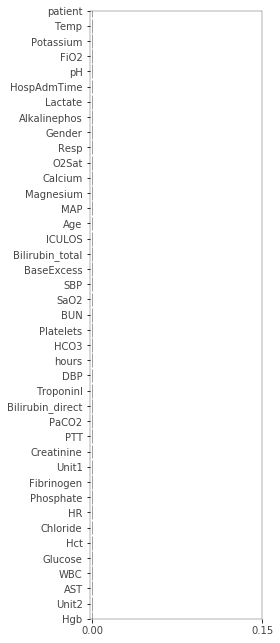

In [38]:
from rfpimp import *

rf = RandomForestClassifier(n_estimators=200,
                            min_samples_leaf=5,
                            n_jobs=-1,
                            oob_score=True, class_weight='balanced')
clf, X_test, y_test = train_stratified(filled, feature_cols, label_col, stratify_col, rf, return_model=True)
imp = importances(clf, X_test, y_test, n_samples=-1)
viz = plot_importances(imp)
viz.view()

# Add Medical Features 

In [134]:
filled['shock_index'] = filled['HR'] / filled['SBP']
filled['BUN/CR'] = filled['BUN'] / filled['Creatinine']

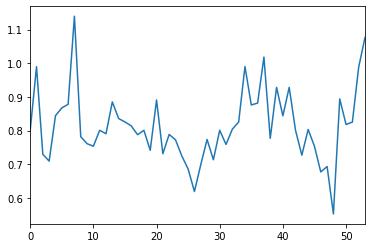

In [57]:
filled.loc[filled['patient'] == 1]['shock_index'].plot()

In [58]:
train_stratified(filled, feature_cols, label_col, stratify_col, RandomForestClassifier(n_estimators=3))

Proportion of positive patients in test set: 0.0953259532595326
train 14643
test 1626
Sum 16269
Total 16269
F1 for train 0.9521700990016291
F1 for test 0.10300429184549358
Train Precision: 98.056%, Recall: 92.538%, Accuracy: 99.799%
Test Precision: 17.590%, Recall: 7.283%, Accuracy: 96.978%


# Add time based features

Sliding-window based features:Mean, minimum, maximum,  median,  variance, 95%,  99%,  5%,and  1% quantiles are calculated from the  last  5  and  11  hours observations. We  use  two  different  time  windows(i.e., 5 and 11 hours) to capture the short-and long-term temporal evolution of each covariate.  

In [196]:
# @Cachable('data_window.csv')
def sliding_window_features(df, features, quantiles=[0.01, 0.05, 0.95, 0.99], windows=[5,11]):
    non_window_features = [c for c in df if c not in features]
    non_window_features_df = df[non_window_features].reset_index(drop=True)
    df = df[features]
    patients = []
    for patient, df in df.groupby('patient'):
        stat_features = []
        quantile_features = pd.DataFrame()
        for w in windows:
            rolling = df.rolling(w).agg(['mean','min', 'max', 'median', 'var']).bfill()
            rolling.columns = [f'_{w}_'.join(col) for col in rolling.columns]
            stat_features.append(rolling)
            for col in df:
                    for q in quantiles:
                        quantile_features[col + '_'  + str(w) +'_' + str(q)] = df[col].rolling(w).quantile(q).bfill()
        stat_features.append(quantile_features)
        window_features = pd.concat(stat_features, axis=1, sort=True)
        final = pd.concat([df, window_features], axis=1, sort=True)
        patients.append(final)
    patients = pd.concat(patients).reset_index(drop=True)
    final_df = pd.concat([patients, non_window_features_df], axis=1, sort=True)
    return final_df

In [197]:
physiological_cols = ['HR', 'O2Sat', 'Temp', 'SBP', 'MAP', 'DBP', 'Resp',
       'BaseExcess', 'HCO3', 'FiO2', 'pH', 'PaCO2', 'SaO2', 'AST', 'BUN',
       'Alkalinephos', 'Calcium', 'Chloride', 'Creatinine', 'Bilirubin_direct',
       'Glucose', 'Lactate', 'Magnesium', 'Phosphate', 'Potassium',
       'Bilirubin_total', 'TroponinI', 'Hct', 'Hgb', 'PTT', 'WBC',
       'Fibrinogen', 'Platelets', 'shock_index','BUN/CR', 'patient' ]

In [251]:
ten = filled[filled['patient'].isin(list(range(13)))]
ten['patient'].nunique()

10

In [252]:
%time ten = sliding_window_features(ten, physiological_cols)

(569, 684)
(569, 8)
CPU times: user 4.09 s, sys: 22.8 ms, total: 4.12 s
Wall time: 4.11 s


In [253]:
ten.to_csv('ten.csv')

In [255]:
read_ten = pd.read_csv('ten.csv')
read_ten

,Unnamed: 0,HR,O2Sat,Temp,SBP,MAP,DBP,Resp,BaseExcess,HCO3,...,patient_11_0.95,patient_11_0.99,Age,Gender,Unit1,Unit2,HospAdmTime,ICULOS,SepsisLabel,hours
0,0,101.578708,91.477313,36.706250,126.831217,87.285304,60.032382,24.811726,23.442342,43.694792,...,1.0,1.0,83.14,0.0,0.506978,0.493022,-0.03,1.0,0.0,0.0
1,1,97.000000,95.000000,36.680198,98.000000,75.330000,60.032382,19.000000,23.324898,43.499905,...,1.0,1.0,83.14,0.0,0.506978,0.493022,-0.03,2.0,0.0,1.0
2,2,89.000000,99.000000,36.726797,122.000000,86.000000,60.032382,22.000000,23.398457,43.758834,...,1.0,1.0,83.14,0.0,0.506978,0.493022,-0.03,3.0,0.0,2.0
3,3,90.000000,95.000000,36.726632,126.861898,88.300336,60.032382,30.000000,24.000000,43.774041,...,1.0,1.0,83.14,0.0,0.506978,0.493022,-0.03,4.0,0.0,3.0
4,4,103.000000,88.500000,36.719624,122.000000,91.330000,60.032382,24.500000,22.840439,44.209125,...,1.0,1.0,83.14,0.0,0.506978,0.493022,-0.03,5.0,0.0,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
564,564,106.000000,94.000000,37.110000,134.000000,81.330000,60.032382,17.830007,-0.670269,22.000000,...,12.0,12.0,81.64,1.0,1.000000,0.000000,-0.03,18.0,0.0,16.0
565,565,98.950267,94.570002,37.503655,131.206040,70.934299,60.032382,17.824534,-0.670269,22.000000,...,12.0,12.0,81.64,1.0,1.000000,0.000000,-0.03,19.0,0.0,17.0
566,566,97.000000,95.000000,36.839123,125.000000,80.330000,60.032382,18.000000,-0.670269,22.000000,...,12.0,12.0,81.64,1.0,1.000000,0.000000,-0.03,20.0,0.0,18.0
567,567,86.000000,95.000000,36.890000,109.492164,65.748908,60.032382,17.711616,-0.670269,22.000000,...,12.0,12.0,81.64,1.0,1.000000,0.000000,-0.03,21.0,0.0,19.0


In [241]:
window = sliding_window_features(filled)
window

# Random under/over sampling 

In [62]:
import imblearn

In [63]:
rebalance_instance = imblearn.over_sampling.SMOTE()
X_train_smote, y_train_smote = rebalance_instance.fit_sample(X_train, y_train)

NameError: name 'X_train' is not defined